In [2]:
import seaborn as sns
import json
import pandas as pd
import numpy as np


def load_data(file: str, label: str, other: bool):
    maps = {}
    syms = {}
    has_syms = False
    with open(file) as f:
        for line in f:
            if line.startswith("{"):
                x = json.loads(line)
                if x.get("type") == "map" and x.get("data", {}) is not None:
                    for k, v in x.get("data").items():
                        maps[k] = v
                if x.get("type") == "printf" and (x["data"].startswith("U ") or x["data"].startswith("K ")):
                    raw: str = x["data"].strip()[2:]
                    addr, sym = raw.split("@", 1)
                    syms[int(addr, 16)] = sym
                    has_syms = True
    map = maps["@instr_samples"] if not other else maps["@instr_samples_other"]
    entries = [(k, v) for k, v in map.items()]
    entries.sort(key=lambda x: x[1], reverse=True)
    total_samples = sum(x[1] for x in entries)
    total_instructions = len(map)
    print(f"[{label}] Total samples: {total_samples}, Total instructions: {total_instructions}")
    entries_w_index = [(float(i + 1) / len(entries), x[0], x[1]) for i, x in enumerate(entries)]
    entries_cumu = []
    s = 0
    for i, x in enumerate(entries_w_index):
        s += x[2]
        entries_cumu.append((x[0], x[1], x[2], s))  # (index, ipaddr, samples, samples.cumulative)
    entries_cumu_norm = [(x[0], x[1], x[2], x[3], x[2] / total_samples, x[3] / total_samples) for x in entries_cumu]
    if has_syms:
        entries_cumu_norm_syms = [(x[0], x[1], x[2], x[3], x[4], x[5], syms.get(int(x[1], 16), "?")) for x in entries_cumu_norm]
        for x in entries_cumu_norm_syms:
            if syms.get(x[1], "?") != "?":
                print(x[1], syms.get(x[1], "?"))
        df = pd.DataFrame(entries_cumu_norm_syms, columns=["ip", "ip.addr", "samples", "samples.cumu", "samples.norm", "samples.cumu.norm", "symbol"])
    else:
        df = pd.DataFrame(entries_cumu_norm, columns=["ip", "ip.addr", "samples", "samples.cumu", "samples.norm", "samples.cumu.norm"])
    # print(df)
    return df


def plot(**files: str):
    dfs = []
    for k, v in files.items():
        if k.endswith("other"):
            df = load_data(v, label=k, other=True)
        else:
            df = load_data(v, label=k, other=False)
        df["gc"] = k
        dfs.append(df)
    df = pd.concat(dfs)

    g = sns.lineplot(data=df, x="ip", y="samples.cumu.norm", hue="gc")

    if g.axes:
        g.axes.grid(True, axis="both")

    g.set_xticks(np.arange(0, 1.1, 0.1))
    g.set_yticks(np.arange(0, 1.1, 0.1))

    return df

# Luseach (No CompressedOops, 512M heap)

[ix] Total samples: 865730, Total instructions: 8041
[lxr] Total samples: 326990, Total instructions: 9073
[g1] Total samples: 322744, Total instructions: 7796
[shen] Total samples: 925520, Total instructions: 7257
[z] Total samples: 2460228, Total instructions: 8282
[par] Total samples: 689247, Total instructions: 6696


[other] Total samples: 18062196, Total instructions: 204254


,ip,ip.addr,samples,samples.cumu,samples.norm,samples.cumu.norm,gc
0,0.000124,0x7d15793fc1c0,80089,80089,9.251037e-02,0.092510,ix
1,0.000249,0x7d1579da1b7a,62291,142380,7.195199e-02,0.164462,ix
2,0.000373,0x7d157905774f,51603,193983,5.960634e-02,0.224069,ix
3,0.000497,0x7d1579639bcc,27711,221694,3.200882e-02,0.256078,ix
4,0.000622,0x7d1578166adb,22176,243870,2.561538e-02,0.281693,ix
...,...,...,...,...,...,...,...
204249,0.999980,0x7729e83f57c1,1,18062192,5.536425e-08,1.000000,other
204250,0.999985,0x7729e122224f,1,18062193,5.536425e-08,1.000000,other
204251,0.999990,0xffffffff95415b85,1,18062194,5.536425e-08,1.000000,other
204252,0.999995,0x7729fff07306,1,18062195,5.536425e-08,1.000000,other


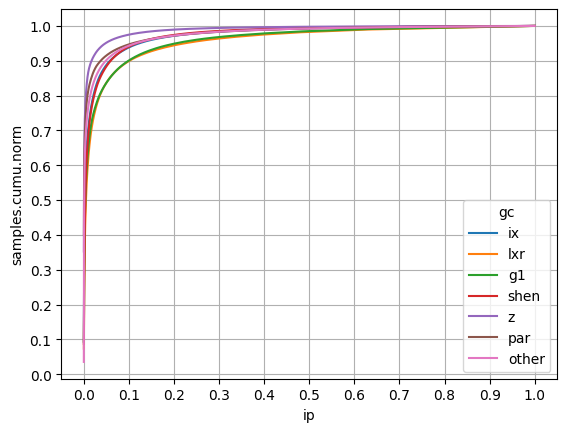

In [6]:
plot(
    ix="../../lusearch-ix.jsonl",
    lxr="../../lusearch-lxr.jsonl",
    g1="../../lusearch-g1.jsonl",
    shen="../../lusearch-shen.jsonl",
    z="../../lusearch-z.jsonl",
    par="../../lusearch-par.jsonl",
    other="../../lusearch-g1.jsonl",
)

# H2 (No CompressedOops, 1G heap)

[ix] Total samples: 21143168, Total instructions: 12298
[lxr] Total samples: 3590639, Total instructions: 11136
[g1] Total samples: 10235384, Total instructions: 15573
[shen] Total samples: 33385677, Total instructions: 8772
[z] Total samples: 45932321, Total instructions: 10095
[par] Total samples: 10019001, Total instructions: 7709
[other] Total samples: 25040341, Total instructions: 243862


,ip,ip.addr,samples,samples.cumu,samples.norm,samples.cumu.norm,gc
0,0.000081,0x76822af66adb,2922421,2922421,1.382206e-01,0.138221,ix
1,0.000163,0x76822af5a3ee,1843165,4765586,8.717544e-02,0.225396,ix
2,0.000244,0x76822af5a40a,1786045,6551631,8.447386e-02,0.309870,ix
3,0.000325,0x76822af82a04,840827,7392458,3.976826e-02,0.349638,ix
4,0.000407,0x76822af82a2c,711153,8103611,3.363512e-02,0.383273,ix
...,...,...,...,...,...,...,...
243857,0.999984,0x7889a48792c2,1,25040337,3.993556e-08,1.000000,other
243858,0.999988,0x78898c20d533,1,25040338,3.993556e-08,1.000000,other
243859,0.999992,0x78898c36afe6,1,25040339,3.993556e-08,1.000000,other
243860,0.999996,0x78898c5e5f76,1,25040340,3.993556e-08,1.000000,other


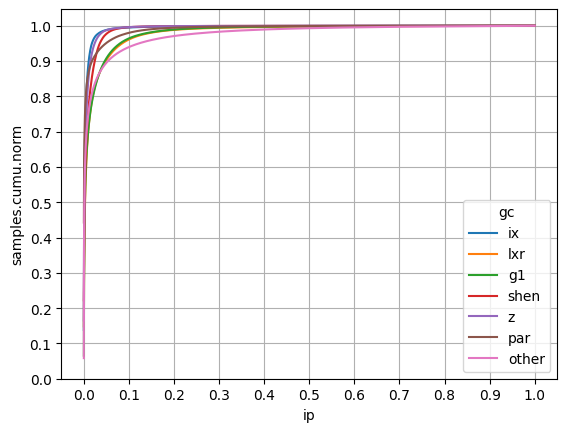

In [7]:
plot(
    ix="../../h2-ix.jsonl",
    lxr="../../h2-lxr.jsonl",
    g1="../../h2-g1.jsonl",
    shen="../../h2-shen.jsonl",
    z="../../h2-z.jsonl",
    par="../../h2-par.jsonl",
    other="../../h2-g1.jsonl",
)

# Kafka (No CompressedOops, 512M heap)

[ix] Total samples: 357414, Total instructions: 5553
[lxr] Total samples: 115293, Total instructions: 6297
[g1] Total samples: 206437, Total instructions: 8226
[shen] Total samples: 396836, Total instructions: 6028
[z] Total samples: 2067530, Total instructions: 6795
[par] Total samples: 523144, Total instructions: 5392
[other] Total samples: 2778605, Total instructions: 201032


,ip,ip.addr,samples,samples.cumu,samples.norm,samples.cumu.norm,gc
0,0.000180,0x786add439bcc,34561,34561,9.669739e-02,0.096697,ix
1,0.000360,0x786adce5774f,28391,62952,7.943449e-02,0.176132,ix
2,0.000540,0x786add1fc1c0,24111,87063,6.745958e-02,0.243591,ix
3,0.000720,0x786adbf66adb,17438,104501,4.878936e-02,0.292381,ix
4,0.000900,0x786adbf5a40a,12735,117236,3.563095e-02,0.328012,ix
...,...,...,...,...,...,...,...
201027,0.999980,0x72723aaee712,1,2778601,3.598928e-07,0.999999,other
201028,0.999985,0x72721cff9a86,1,2778602,3.598928e-07,0.999999,other
201029,0.999990,0x72721d600193,1,2778603,3.598928e-07,0.999999,other
201030,0.999995,0x72723ab9dce5,1,2778604,3.598928e-07,1.000000,other


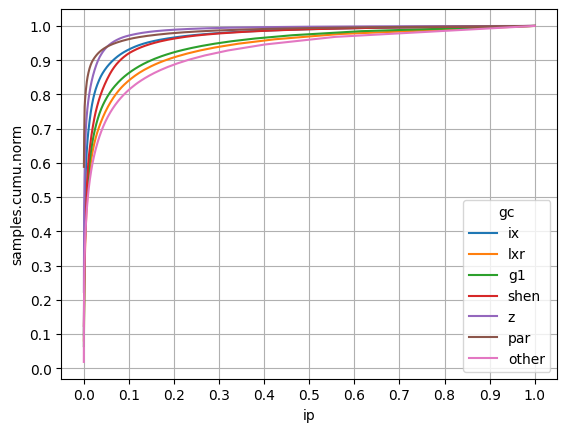

In [8]:
plot(
    ix="../../kafka-ix.jsonl",
    lxr="../../kafka-lxr.jsonl",
    g1="../../kafka-g1.jsonl",
    shen="../../kafka-shen.jsonl",
    z="../../kafka-z.jsonl",
    par="../../kafka-par.jsonl",
    other="../../kafka-g1.jsonl",
)

# Top Symboles (lxr, lusearch)

* Side metadata
  * `mmtk::util::metadata::side_metadata::global::SideMetadataSpec::side_metadata_access`
* Transitive Closur Packet:
  * `mmtk::scheduler::gc_work::_$LT$impl$u20$mmtk..scheduler..work..GCWork$LT$$LT$E$u20$as$u20$mmtk..scheduler..gc_work..ProcessEdgesWork$GT$..VM$GT$$u20$for$u20$E$GT$::do_work`
* Copying:
  * `__memmove_avx512_unaligned_erms`
  * `mmtk::util::copy::GCWorkerCopyContext$LT$VM$GT$::post_copy`
  * `mmtk::policy::immix::immixspace::ImmixSpace$LT$VM$GT$::acquire_blocks`
* RC Increments:
  * `_$LT$mmtk..plan..lxr..rc..ProcessIncs$LT$VM$C$_$GT$$u20$as$u20$mmtk..scheduler..work..GCWork$LT$VM$GT$$GT$::do_work`

[lxr] Total samples: 73347, Total instructions: 5256

    %   %.cumulative   symbol
0.069          0.069   mmtk::util::metadata::side_metadata::global::SideMetadataSpec::side_metadata_access::h8c94a8402b3d5a6d
0.030          0.099   mmtk::scheduler::gc_work::_$LT$impl$u20$mmtk..scheduler..work..GCWork$LT$$LT$E$u20$as$u20$mmtk..scheduler..gc_work..ProcessEdgesWork$GT$..VM$GT$$u20$for$u20$E$GT$::do_work::hfdbf444f3eccd316
0.025          0.123   native_queued_spin_lock_slowpath
0.024          0.147   finish_task_switch.isra.0
0.022          0.169   ClassLoaderDataGraphKlassIteratorAtomic::next_klass()
0.019          0.188   mmtk::util::metadata::side_metadata::global::SideMetadataSpec::side_metadata_access::hdad17558a16f8a5c
0.018          0.206   __memmove_avx512_unaligned_erms
0.018          0.224   clear_page_erms
0.017          0.241   mmtk::scheduler::gc_work::_$LT$impl$u20$mmtk..scheduler..work..GCWork$LT$$LT$E$u20$as$u20$mmtk..scheduler..gc_work..ProcessEdgesWork$GT$..VM$GT$$u20$fo

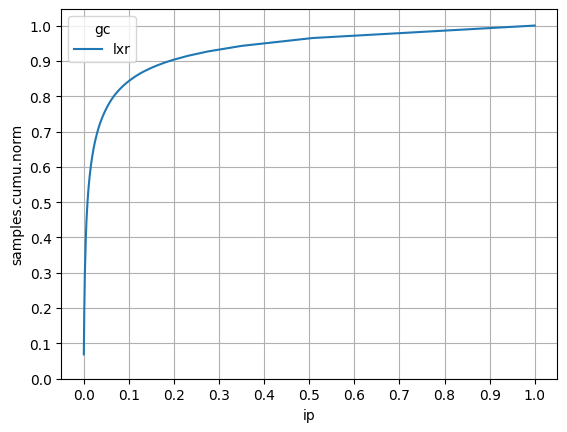

In [24]:
df = plot(
    lxr="../../lusearch-lxr-syms.jsonl",
)
print()
print("    %   %.cumulative   symbol")
for index, row in df.iterrows():
    print(f"{row['samples.norm']:.3f}", f"         {row['samples.cumu.norm']:.3f}  ", row["symbol"])
    if row["samples.cumu.norm"] > 0.90 or row["samples.norm"] <= 0.008:
        break